In [1]:
#-----------------------------------------------------------------------------------------------------------------
#importing libraries
from __future__ import print_function, division
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import argparse
import copy
import datetime
import math
from matplotlib.gridspec import GridSpec
global low, up
from astropy.io import fits as f
from astropy.table import Table as t
from astropy.utils.data import download_file
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
from mpl_toolkits import mplot3d
from scipy.optimize import curve_fit
import scipy.optimize as so
import warnings
warnings.filterwarnings("ignore")
#-----------------------------------------------------------------------------------------------------------------

In [2]:
#importing data from my GitHub
url2 = 'https://raw.githubusercontent.com/jovian-explorer/Sun/main/MOM/output_expdopp_4point_287.txt'
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', None)
dataset2 = pd.read_csv(url2,delimiter = '\t')
print(dataset2.head(5))
dataset2.columns = ["i","timesec","power_total","dopp_firstmoment","second_moment",'exp_dopp']
second_moment = np.array(dataset2.second_moment)	        # Values of second_moment
timesec = np.array(dataset2.timesec)	
zeroth_moment= np.array(dataset2.power_total)  
first_moment= np.array(dataset2.dopp_firstmoment)  
second_moment= np.array(dataset2.second_moment)  
exp_dopp= np.array(dataset2.exp_dopp)            	        # Values of exp_dopp
# -----------------------------------------------------------------------------------------------------------------

   i timesec   power_total   dopp_firstmoment   second_moment   Unnamed: 4  \
0           1      10230.00           0.077761        0.835513    0.747926   
1           1      10230.25           0.073983        0.797783    0.710946   
2           1      10230.50           0.062547        0.888351    1.422530   
3           1      10230.75           0.068714        0.789309    0.704040   
4           2      10231.00           0.072142        0.852026    0.763118   

       exp_dopp  
0 -6.114542e+09  
1 -6.114542e+09  
2 -6.114542e+09  
3 -6.114542e+09  
4 -6.114542e+09  


In [3]:
#importing data from my GitHub
url = 'https://raw.githubusercontent.com/jovian-explorer/Sun/main/MOM/freqres_2021-287T.txt'
#ET_time(sec) 	 time(sec of day) 	 freq_residual(Hz=exp-theo) 	 exp_dopp 	 theo_dopp 
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', None)
dataset = pd.read_csv(url,delimiter = '\t')
print(dataset.head(5))
dataset.columns = ["ET_time(sec)", 	 "time(sec of day)", 	 "freq_residual(Hz=exp-theo)", 	 "exp_dopp" ,	 "theo_dopp" ] 
et = np.array(dataset["ET_time(sec)"])
freq_residual= np.array(dataset["freq_residual(Hz=exp-theo)"])  
exp_dopp= np.array(dataset["exp_dopp"])            	        # Values of exp_dopp
theo_dopp = np.array(dataset["theo_dopp"])	                        # Values of theo_dopp




   ET_time(sec)    time(sec of day)    freq_residual(Hz=exp-theo)   \
0   6.874521e+08            10405.00                  -2892.886093   
1   6.874521e+08            10405.25                  -2892.150709   
2   6.874521e+08            10405.50                  -2889.811024   
3   6.874521e+08            10405.75                  -2890.442937   
4   6.874521e+08            10406.00                  -2890.537751   

    exp_dopp    theo_dopp   
0  18008.4160  20901.30209  
1  18009.1198  20901.27051  
2  18011.4279  20901.23892  
3  18010.7644  20901.20734  
4  18010.6380  20901.17575  


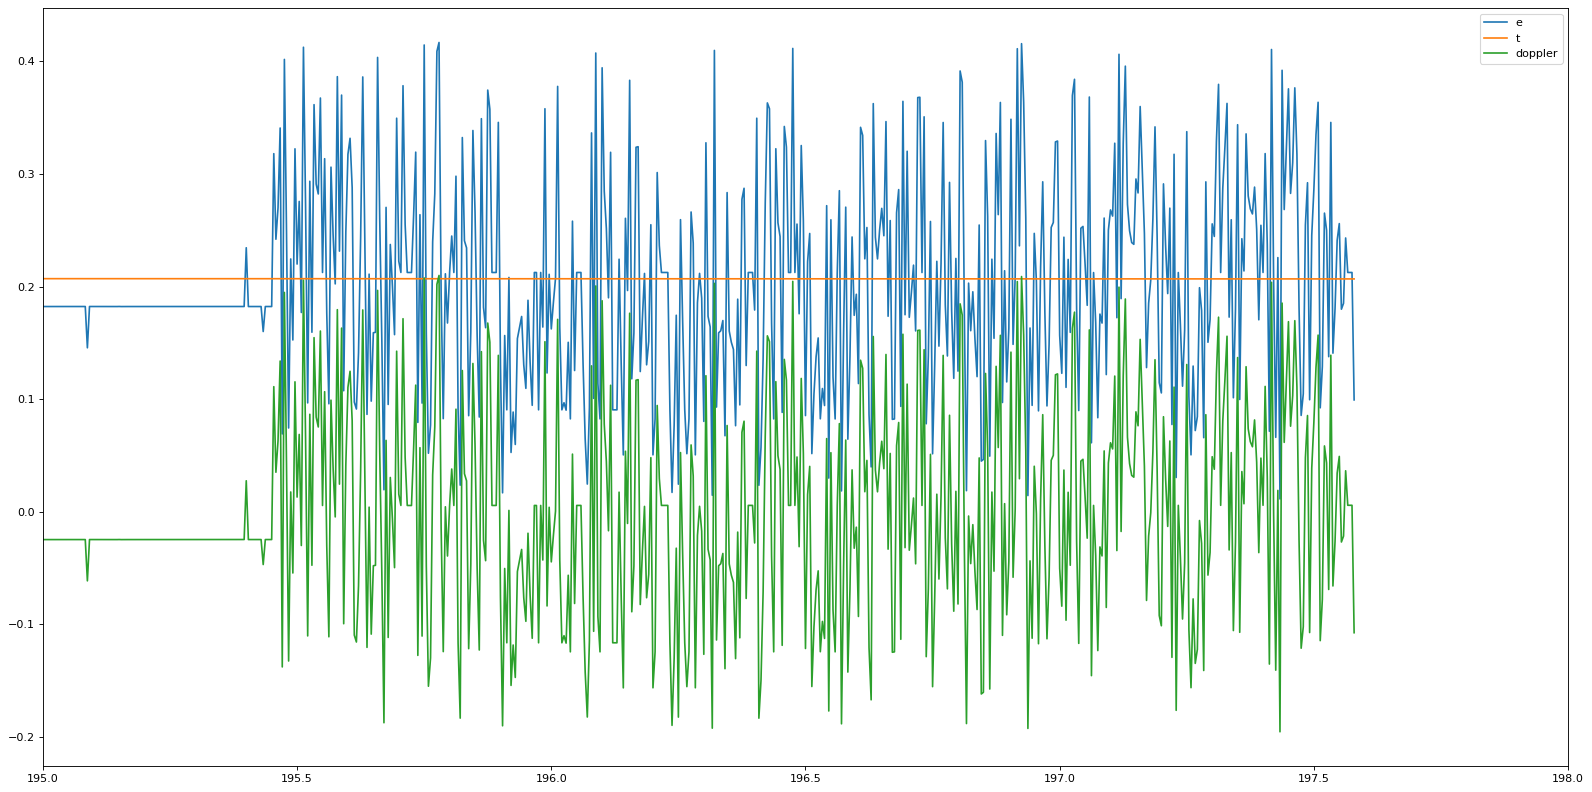

In [4]:
# -----------------------------------------------------------------------------------------------------------------
fig = plt.figure(figsize = (20,10) , dpi= 80) 

plt.plot(timesec[:-700]/60,exp_dopp/10**5,label="e")
plt.plot(timesec[:-700]/60,theo_dopp/10**5,label="t")
plt.plot(timesec[:-700]/60,freq_residual/10**5,label="doppler")
plt.legend(loc = 'best')
plt.xlim(195,198)
plt.tight_layout()
plt.show()

In [14]:
#------------------------------------------------
m =9.1*10**(-31) #mass of electron
e = 1.6*10**(-19) #charge of electron
downconfreq =2310# 2.3MHz#*10**9
k= 7.705*10**3 #7671.976953385#7692 Wavenumber
l_2= 2.244e+8 #1.52AU 
alpha = 1.14*10**(-24)
L =3.9195e+8 #2.62AU
ds=(4.01 *10**8)/timesec[-1]
R = 1.287e+7 #17.5 solar radii
epsilon = 8.85* 10**(-12)
bandwidth = np.mean(exp_dopp)#2*(max(exp_dopp)-min(exp_dopp))
#------------------------------------------------
print(timesec[-1])
print(len(timesec))

12029.75
7200


In [15]:
RTEC = (second_moment-(alpha*(downconfreq/1000)**(-1.2)))**(1/1.2)  #freq in ghz

density = RTEC/(17.5*10**8) #R in solar radii,RTEC per m3
plasma_frequency_model_2 = np.sqrt((density*(e**2))/(m*epsilon))#Chen F. F., 1974

# refractive index equation taken from Hollweg et al. 1970
d_refractive_index_model_2 =(-1/2)*((plasma_frequency_model_2**2/downconfreq**2))*(np.gradient(density)/density)
d_refractive_index_model_2 = np.nan_to_num(d_refractive_index_model_2)

dy = np.gradient(second_moment)

#angular broadening taken from Hollweg et al. 1970
temp_2 = d_refractive_index_model_2/dy
temp_2 = temp_2*ds
angular_broadening_model_2 = np.sum(temp_2)

#Solar wind velocity taken from Bird et al. 1982
solar_wind_velocity_model_2 = (5.77*bandwidth*L)/(angular_broadening_model_2*k*l_2)

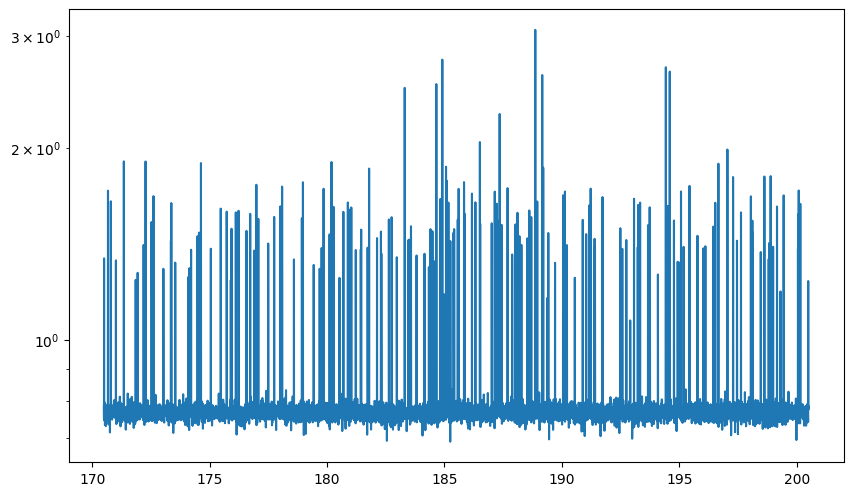

In [16]:
plt.figure(figsize=(10,6),dpi=100)
plt.plot(timesec/60,RTEC)
plt.yscale('log')
plt.show()

In [17]:
print("RTEC  " + str(RTEC)+ '\n')

print("density  " + str(density)+ '\n')

print("plasma_frequency_model_2  " + str(plasma_frequency_model_2)+ '\n')

print("d_refractive_index_model_2  " + str(d_refractive_index_model_2)+ '\n')

print("angular_broadening_model_2 " + str(angular_broadening_model_2)+ '\n')

print("solar_wind_velocity_model_2  " + str(solar_wind_velocity_model_2/10**3)+ '\n')  #1483 km/s? km/h?? what?

RTEC  [0.78502223 0.75254185 1.34137829 ... 1.23556894 0.77540811 0.78520231]

density  [4.48584130e-10 4.30023916e-10 7.66501877e-10 ... 7.06039395e-10
 4.43090346e-10 4.48687034e-10]

plasma_frequency_model_2  [0.00119412 0.00116916 0.00156093 ... 0.0014981  0.00118679 0.00119426]

d_refractive_index_model_2  [ 5.52820761e-15 -4.73463085e-14  5.18860604e-16 ... -2.81641332e-15
  3.83265306e-14 -1.66698790e-15]

angular_broadening_model_2 -3.574960216008437e-05

solar_wind_velocity_model_2  -673.5573087507353



#### RTEC

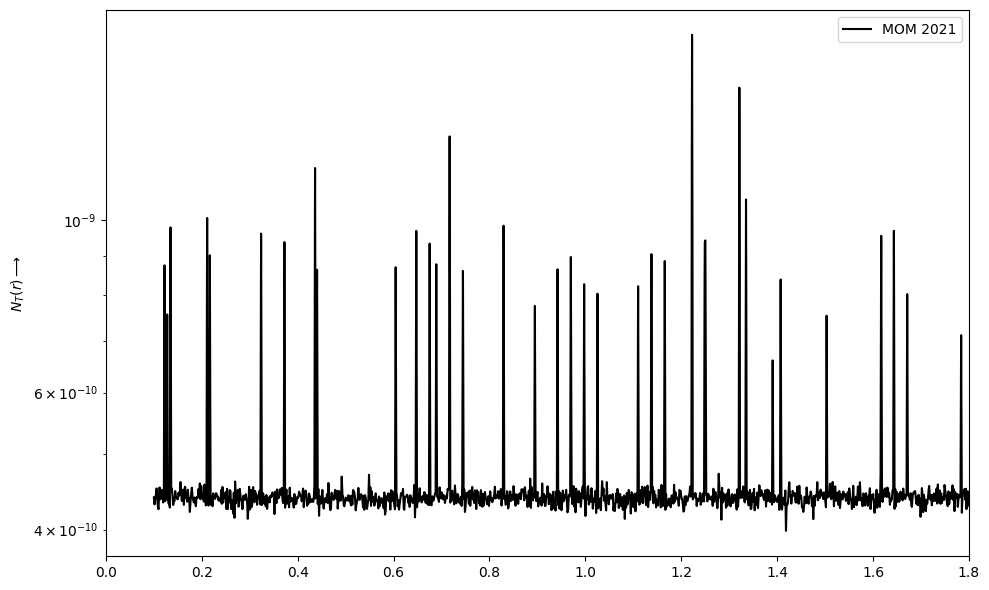

In [9]:
import numpy as np
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(10,6),dpi=100)
theta =90 # np.arange(0, 90, 0.0009)
r = np.arange(0.1,5.1,0.00005)

nom = len(density)
density_2 = density[3600:]

density_interp = interp.interp1d(np.arange(density_2.size),density_2)
density_stretch = density_interp(np.linspace(0,density_2.size-1,r.size))


A = (((1.55* (10**14)) / r**6)  + (3.44*(10**11)))* (((np.cos(theta*np.pi))**2 * (1/64)*(np.sin(theta))**2)**(-1/2))   # Tyler et al. 1977
B = (((2.39* (10**14)) / r**6)  + (1.67*(10**12)/ (r**(2.3))))*(10**(-0.9*theta*np.pi/90))                             # Beman et al. 1977
C = (1.58* 10**17)/((r-1)**2)                                                                                          # Cairns et al. 2009
D = 14.2*(10**10)*(10**(4.32/r))                                                                                       # Newkirk et al. 1961
E = (10**14)*((2.99/(r**16))+(1.55/(r**6)))                                                                            # Allen-Baubach et al. 1947
F = (10**12)*((65/(r**5.94))+(0.768/((r-1)**2.25)))                                                                    # Wexler et al. 2019
G = ((8* 10**13)/(r**6))+((4.1* 10**12)/(r**4))+((3.3* 10**11)/(r**2))                                                 # LeBlanc et al. 1998 
H = (10**12)*((30/r**6)+(1/r**2.2))                                             # HELIOS 2                             # Patzold et al. 1987
I = (10**12)*((100/r**6)+(0.5/r**2.1))                                          # HELIOS 2                             # Esposito et al. 1980
J = (10**12)*((1.32/r**2.7)+(0.23/r**2.04))                                     # VIKING                               # Muhleman et al 1981
K = (10**12)*((30/r**6)+(1/r**2.2))                                             #1976 HELIOS DATA                      # Edenhofer et al. 1977

# # %matplotlib qt
# plt.plot(r,E/10**16, label = "Allen et al. 1947")
# plt.plot(r,D/10**16, label = "Newkirk et al. 1961")
# plt.plot(r,A/10**16, label ="Tyler et al. 1977")
# # plt.plot(r,B/10**16, label = "Beman et al. 1977")
# plt.plot(r,K/10**16, label = "Edenhofer et al. 1977")
# plt.plot(r,I/10**16, label = "Esposito et al. 1980")
# plt.plot(r,J/10**16, label = "Muhleman et al. 1981")
# plt.plot(r,H/10**16, label = "Patzold et al. 1987")
# plt.plot(r,G/10**16, label = "LeBlanc et al. 1998")
# # plt.plot(r,C/10**16, label = "Cairns et al. 2009")
# # plt.plot(r,F/10**16, label = "Wexler et al. 2019")

# plt.scatter(r,density_stretch,s= 0.001, color ='k',label="MOM 2021")
plt.plot(r,density_stretch,'k-',label="MOM 2021")
plt.yscale('log')
# plt.title("Electron Density in IPS")
# plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='best')
# plt.ylim(10**(-8),10**15)
plt.xlim(0,1.8)
plt.ylabel("$N_T(r) \longrightarrow$")
# plt.xlabel("Distance b/w Sun and probe (in AU) ")
plt.tight_layout()
# plt.savefig('models_density.png')
plt.show()
